# 배포판. 2025.3.28

## DAVID visualization

### Index
A. Dot-plot
- Visualize one annotational chart
- Visualize two annotational charts

### A. Dot-plot
- __Visualize one annotational chart__
- Visualize two annotational charts

### Step 1. Call, define the modules and functions.
아래 셀을 반드시 실행할 것.

In [2]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns



def preprocess_david(data):
    # GeneRatio = Count / List Total
    data.loc[:, 'GeneRatio'] = data.loc[:, 'Count'] / data.loc[:, 'List Total']

    # BgRatio = Pop Hits / Pop Total
    data.loc[:, 'BgRatio'] = data.loc[:, 'Pop Hits'] / data.loc[:, 'Pop Total']

    # log2 transformed fold enrichment
    data.loc[:, 'log2 Fold Enrichment'] = np.log2(data.loc[:, 'Fold Enrichment'])
    #data[:, 'log2 Fold Enrichment'] = np.log2(data[:, 'Fold Enrichment'])
    
    # Replace 0 to min value from that column
    pvals = ['PValue', 'Bonferroni', 'Benjamini']
    for pval in pvals:
        # Assuming your DataFrame is named 'df'
        filtered_df = data[data[pval] != 0]
        min_non_zero = filtered_df[pval].min()

        #min_non_zero = data[pval][data[pval] != 0].min
        data[pval] = data[pval].replace(0, min_non_zero)

    # Fisher E
    data['-log10(PValue)'] = np.log10(data['PValue'])
    data.loc[:, '-log10(PValue)'] *= -1
    return data


def pick_go_term(data, type="bp", x="fold_enrichment", p="pvalue", top=10):
    """
    - type: bp, cc, mf, kegg
    - x: fold_enrichment, gene_ratio, fisherp
    - p: pvalue, fdr
    """
    # axis_Y (Annotation Term)
    global fig_title
    global axis_X
    global adj_p

    if type == "bp":
        data_tmp = data[data['Category'] == "GOTERM_BP_DIRECT"]
        fig_title = "GOBP"
    elif type == "cc":
        data_tmp = data[data['Category'] == "GOTERM_CC_DIRECT"]
        fig_title = "GOCC"
    elif type == "mf":
        data_tmp = data[data['Category'] == "GOTERM_MF_DIRECT"]
        fig_title = "GOMF"
    elif type == "kegg":
        data_tmp = data[data['Category'] == "KEGG_PATHWAY"]
        fig_title = "KEGG"
    else:
        raise ValueError

    # axis_X ()
    if x == "fold_enrichment":
        axis_X = "log2 Fold Enrichment"
    elif x == "gene_ratio":
        axis_X = "GeneRatio"
    elif x == "fisherp":
        axis_X = "-log10(PValue)"
    else:
        raise ValueError

    # p
    if p == "pvalue":
        adj_p = "PValue"
        thres = 0.05
    elif p == "fdr":
        adj_p = p.upper()
        thres = 0.01
    else:
        raise ValueError
    
    # Picking
    data_p = data_tmp[data_tmp[adj_p] <= thres]
    data_sort = data_p.sort_values(by=axis_X, ascending=False)
    data = data_sort[:top]
    return data


def adaptive_dot_size(figsize, num_points, base_factor=2000):
    width, height = figsize
    return max(5, min(200, base_factor / (num_points * width * height)))


def plot(data, w, h, cbar_size = 0.5, dpi=150):
    # GeneOntology Dot Plot Generator
    font = {'family':'Arial',
            'weight':'normal',
            'size':6}
    font_ticks = {'family':'Arial',
                'weight':'normal',
                'size':6}
    spectrum_colors = sns.color_palette("coolwarm_r", as_cmap=True)
    figsize = (w, h)
    SCALE_FACTOR = int(h/w)
    dot_size = adaptive_dot_size(figsize, len(data))
    CSIZE = cbar_size
    DPI = dpi

    fig = plt.figure(figsize=figsize, dpi=DPI, facecolor="white")
    scatterplot = sns.scatterplot(data, x=axis_X, y="Term", size="Count", hue="PValue", palette='coolwarm_r', legend="brief")

    # Custom legends
    h, l = scatterplot.get_legend_handles_labels()
    plt.legend(h[6:], l[6:], bbox_to_anchor=(1.0, 0.5), loc="upper left", frameon=False, borderaxespad=0., fontsize=6, title_fontsize=6)
    #plt.legend(bbox_to_anchor=(1.0, 0.5), loc="upper left", frameon=False, borderaxespad=0., fontsize=6, title_fontsize=6)


    # ColorBar
    cmap = cm.coolwarm_r
    VMIN = data['PValue'].min()
    #VMAX = data['PValue'].max()
    #vmm = vmin + vmax
    #norm = mpl.colors.Normalize(vmin=VMIN, vmax=VMAX)
    norm = mcolors.LogNorm(vmin=VMIN, vmax=0.05)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=plt.gca(), fraction=0.04, pad=0.05, anchor=(1.0, 0.9), format='%.0e', shrink=CSIZE, aspect=10) # shrink reduces height (0.5 = 50% of orig)
    cbar.ax.spines['outline'].set_visible(False) # outline remove
      
    #cbar.set_label('Adj.P', size=6, loc='top', rotation=0, labelpad=0)
    cbar.ax.tick_params(axis='y', which='both', direction='inout', length=0, width=0, labelsize=4)
    #cbar.ax.invert_yaxis() # colorbar를 180 돌림.
    
    # ticks만 역순으로 나오게.
    #ticks = cbar.get_ticks()
    #cbar.set_ticks(ticks[:])

    # Details
    plt.title(str(fig_title), font='Arial', size=8)
    plt.xlabel(str(axis_X), fontdict=font)
    plt.ylabel(None)
    plt.xticks(fontproperties=font_ticks)
    plt.yticks(fontproperties=font_ticks)

    # Add grid lines to both x and y axes with gray color and a lower z-order
    plt.grid(True, color='gray', linewidth=0.2, zorder=0)

    plt.show()

#### Bug report
Noted two replicated "Count" legend title.

### Your Data

C:\Users\simhc\AppData\Local\Temp\ipykernel_26908\1168949839.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(filepath_or_buffer=DPATH+'up-1_5-nucleus.txt', sep="\\t", encoding='utf-8')


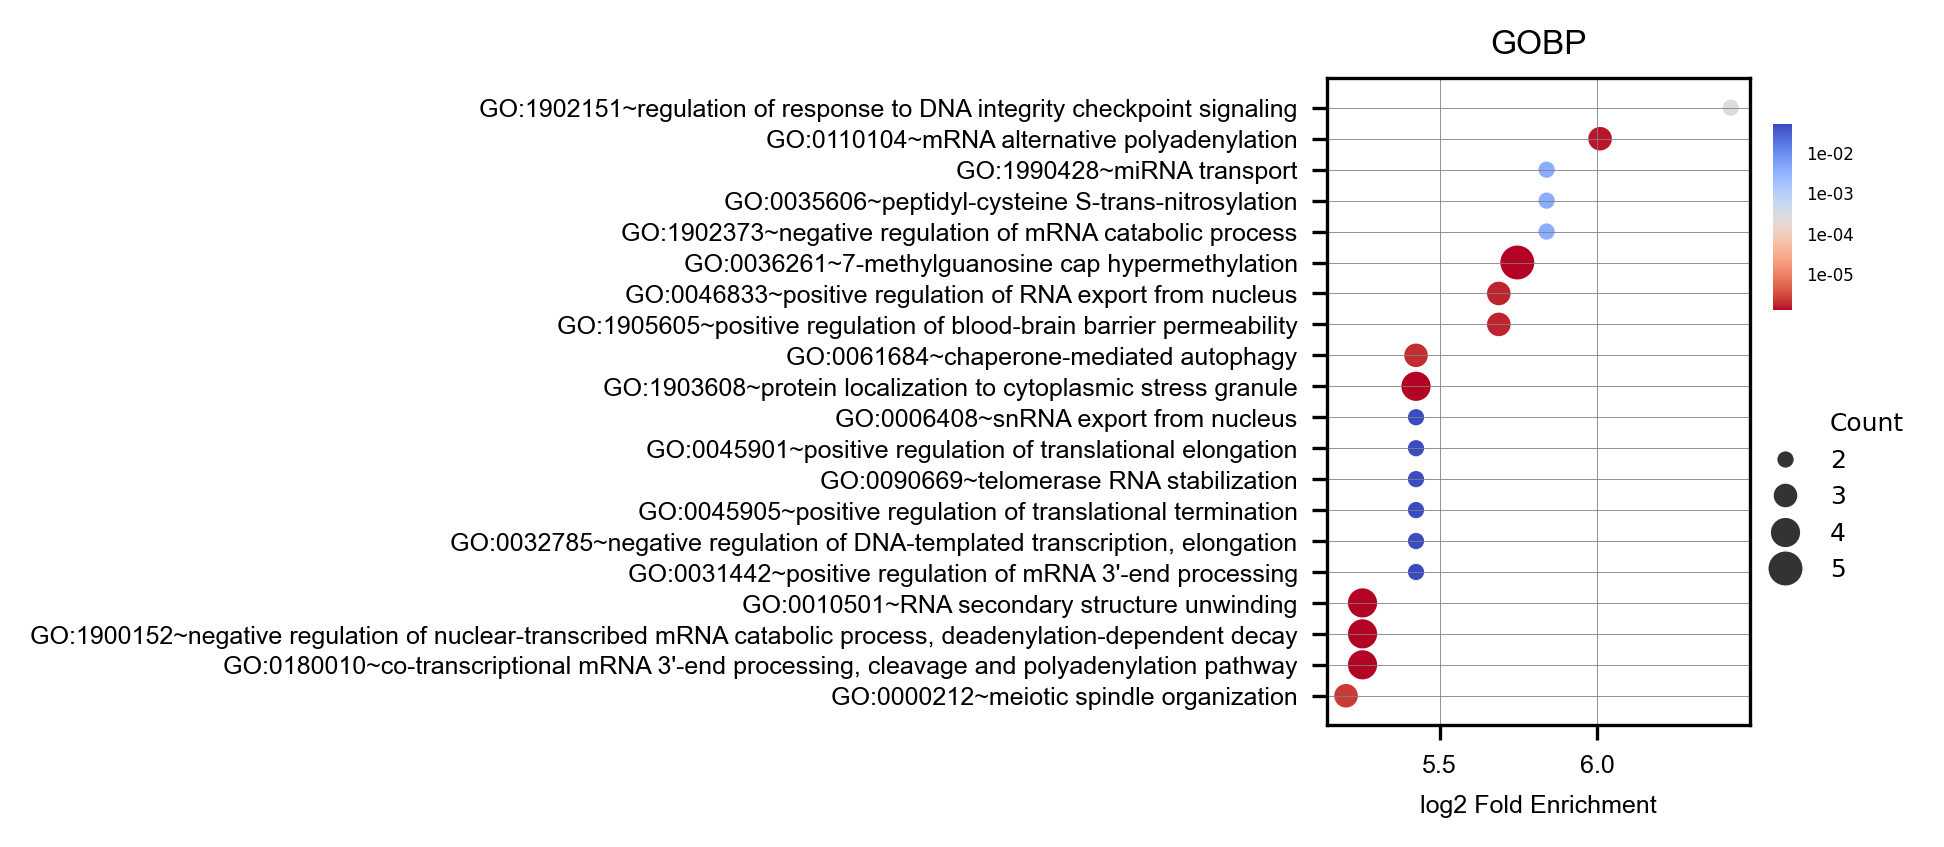

In [ ]:
import os
import pandas as pd


# Constant
LOGGEDUSER = os.getlogin()


# DAVID 에서 다운받은 결과 파일 (*.txt)의 경로를 입력. 확장자까지.
DPATH = 'C:/Users/simhc/OneDrive/Documents/_ProteomicsLAB/_proj/PCa_HMGN1/_IPMS/up-1_5-nucleus.txt'


# 여기서부터
df = pd.read_csv(filepath_or_buffer=DPATH, sep="\\t", encoding='utf-8')
df_ready = preprocess_david(df)
# 여기까지 변경 금지


# 여기서부터는 파라미터만 맞게 입력하기.
# type: bp, cc, mf, kegg
# x: fold_enrichment, gene_ratio
# top: 정수형 숫자.

# step 1. visualize 할 데이터 범위 선택.
df_plot = pick_go_term(df_ready, type="bp", x="fold_enrichment", p="pvalue", top=20)

# 변경금지
plot(df_plot, w=2, h=2.8, cbar_size=1.0, dpi=300)
# 여기까지


# 됐으면 ctrl + enter 실행.
# 파일 저장 및 복사는 이미지 위에 커서 올리면 버튼 나옴.